In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms,datasets
from torch.utils.data import DataLoader

In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda")

In [3]:
mnist_train = datasets.MNIST("../data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("../data", train=False, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(mnist_train, batch_size = 100, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = 100, shuffle=False)

In [4]:
def standard_epoch(data_loader, model, loss_fn, optimizer = None):
    epoch_total_loss = 0.0
    epoch_total_correct = 0
    
    for X, y in data_loader:
        #send data to device
        X = X.to(device)
        y = y.to(device)
        
        #get the model prediction
        y_pred = model(X)
        
        #compute loss with respect to the true labels
        loss = loss_fn(y_pred, y)
        
        #if an optimizer is passed, perform a step
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        #add the loss to the total loss for the epoch (multiply by the batch size to keep the scale consistent)
        epoch_total_loss += loss.item() * X.shape[0]
        
        #compute the number of correct predictions
        epoch_total_correct += torch.sum(y_pred.argmax(dim=1) == y).item()
        
    #return the average loss and accuracy for the epoch
    return epoch_total_loss / len(data_loader.dataset), epoch_total_correct / len(data_loader.dataset)
        

In [34]:
def adversarial_epoch(data_loader, model, loss_fn, attack_fn, epsilon, optimizer=None, **kwargs):
    epoch_total_loss = 0.0
    epoch_total_correct = 0
    
    for X, y in data_loader:
        #send data to device
        X = X.to(device)
        y = y.to(device)
        
        #generate adversarial perturbation
        delta = attack_fn(model, X, y, loss_fn, epsilon, **kwargs)
        X_adv = X + delta
        
        #get the model prediction on the adversarial example
        y_pred = model(X_adv)
        
        #compute loss with respect to the true labels
        loss = loss_fn(y_pred, y)
        
        #if an optimizer is passed, perform a step
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        #add the loss to the total loss for the epoch (multiply by the batch size to keep the scale consistent)
        epoch_total_loss += loss.item() * X.shape[0]
        
        #compute the number of correct predictions
        epoch_total_correct += torch.sum(y_pred.argmax(dim=1) == y).item()
        
    #return the average loss and accuracy for the epoch
    return epoch_total_loss / len(data_loader.dataset), epoch_total_correct / len(data_loader.dataset)

In [20]:
def train_standard_model(model, train_loader, test_loader, loss_fn, optimizer, num_epochs):
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    
    print(*(i.format(i) for i in ("Train Loss", "Test Loss", "Train Error", "Test Error")), sep="\t")
    for epoch in range(num_epochs):
        # model.train()
        train_loss, train_accuracy = standard_epoch(train_loader, model, loss_fn, optimizer)
        # model.eval()
        test_loss, test_accuracy = standard_epoch(test_loader, model, loss_fn)
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        
        print(*("{:.6f}".format(i) for i in (train_loss, test_loss, train_accuracy, test_accuracy)), sep="\t")
        
    return train_losses, test_losses, train_accuracies, test_accuracies

In [21]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1) 

model_cnn = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
                          nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                          Flatten(),
                          nn.Linear(7*7*64, 100), nn.ReLU(),
                          nn.Linear(100, 10)).to(device)

In [22]:
model_cnn_optimizer = optim.SGD(model_cnn.parameters(), lr=1e-1)
model_cnn_loss_fn = nn.CrossEntropyLoss()

In [23]:
#train the model
train_losses, test_losses, train_accuracies, test_accuracies = train_standard_model(model_cnn, train_loader, test_loader, model_cnn_loss_fn, model_cnn_optimizer, 10)

Train Loss	Test Loss	Train Error	Test Error
0.637801	0.087983	0.782533	0.972700
0.083127	0.055589	0.974883	0.983000
0.053866	0.048783	0.983667	0.983400
0.040430	0.044174	0.986933	0.985800
0.031464	0.037264	0.989967	0.988300
0.023503	0.045735	0.992783	0.986000
0.018919	0.043843	0.994017	0.986400
0.015659	0.041349	0.995050	0.989600
0.013612	0.051109	0.995450	0.986900
0.011113	0.046695	0.996433	0.987500


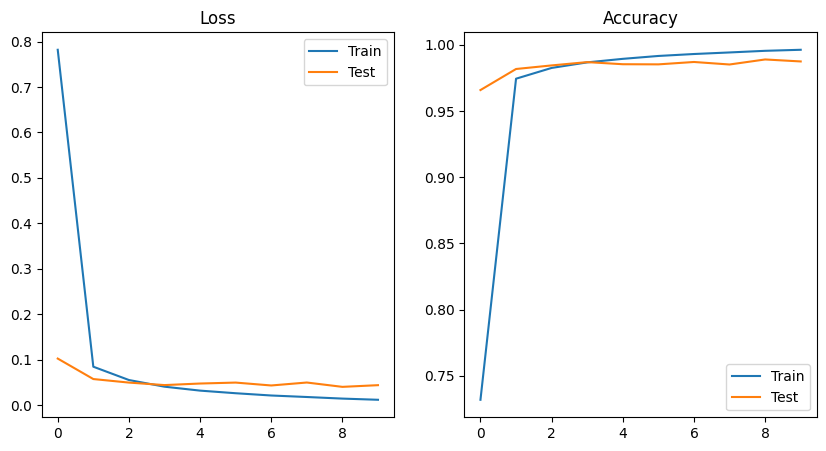

In [11]:
def plot_model_training(train_losses, test_losses, train_accuracies, test_accuracies):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].plot(train_losses, label="Train")
    axs[0].plot(test_losses, label="Test")
    axs[0].set_title("Loss")
    axs[0].legend()

    axs[1].plot(train_accuracies, label="Train")
    axs[1].plot(test_accuracies, label="Test")
    axs[1].set_title("Accuracy")
    axs[1].legend()

    plt.show()
    
plot_model_training(train_losses, test_losses, train_accuracies, test_accuracies)

In [12]:
#attack methods from before
def fgsm(model, X, y, loss_fn, epsilon=0.1):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    loss = loss_fn(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()

In [14]:
def evaluate_model_on_adversarial_examples(model, data_loader, loss_fn, attack_fn, epsilon, **kwargs):
    model.eval()
    test_loss, test_accuracy = adversarial_epoch(data_loader, model, loss_fn, attack_fn, epsilon, **kwargs)
    
    return test_loss, test_accuracy

In [66]:
def evaluate_model_accuracy_for_epsilons(model, data_loader, loss_fn, attack_fn, epsilon_values, **kwargs):
    accuracies = []
    
    for epsilon in epsilon_values:
        _, accuracy = evaluate_model_on_adversarial_examples(model, data_loader, loss_fn, attack_fn, epsilon, **kwargs)
        accuracies.append(accuracy)
        
    return accuracies

In [16]:
cnn_accs_for_epsilons = evaluate_model_accuracy_for_epsilons(model_cnn, test_loader, model_cnn_loss_fn, fgsm, np.linspace(0, 0.3, 10))

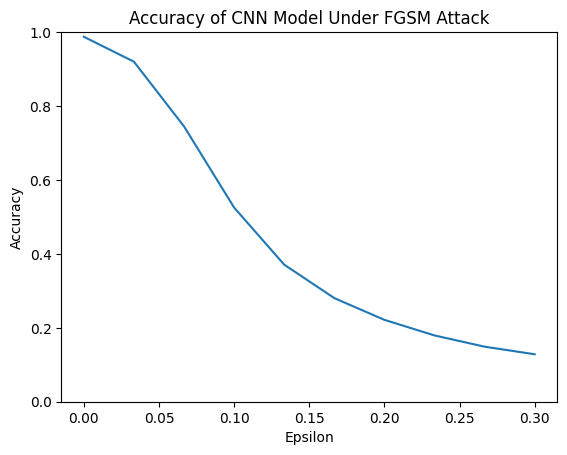

In [18]:
#plot the accuracy as a function of epsilon
plt.plot(np.linspace(0, 0.3, 10), cnn_accs_for_epsilons)
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.ylim([0, 1])
plt.title("Accuracy of CNN Model Under FGSM Attack")
plt.show()


In [31]:
robust_model_cnn = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
                          nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                          Flatten(),
                          nn.Linear(7*7*64, 100), nn.ReLU(),
                          nn.Linear(100, 10)).to(device)

robust_model_cnn_optimizer = optim.SGD(robust_model_cnn.parameters(), lr=1e-1)
robust_model_cnn_loss_fn = nn.CrossEntropyLoss()

In [32]:
def train_robust_model(model, train_loader, test_loader, loss_fn, optimizer, num_epochs, attack_fn, epsilon, **kwargs):
    train_losses = []
    test_losses = []
    adv_losses = []
    train_accuracies = []
    test_accuracies = []
    adv_accuracies = []
    
    print(*(i.format(i) for i in ("Train Loss", "Test Loss", "Adv Loss", "Train Accuracy", "Test Accuracy", "Adv Accuracy")), sep="\t")
    for epoch in range(num_epochs):
        #train the model on adversarial constructed examples
        train_loss, train_accuracy = adversarial_epoch(train_loader, model, loss_fn, attack_fn, epsilon, optimizer, **kwargs)
        #evaluate the model on the test set
        test_loss, test_accuracy = standard_epoch(test_loader, model, loss_fn)
        #evaluate the model on adversarial examples
        adv_loss, adv_accuracy = adversarial_epoch(test_loader, model, loss_fn, attack_fn, epsilon, **kwargs)
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        adv_losses.append(adv_loss)
        
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        adv_accuracies.append(adv_accuracy)
        
        print(*("{:.6f}".format(i) for i in (train_loss, test_loss, adv_loss, train_accuracy, test_accuracy, adv_accuracy)), sep="\t")
        
    return [train_losses, test_losses, adv_losses, train_accuracies, test_accuracies, adv_accuracies]

In [35]:
results = train_robust_model(robust_model_cnn, train_loader, test_loader, robust_model_cnn_loss_fn, robust_model_cnn_optimizer, 10, fgsm, 0.1)

Train Loss	Test Loss	Adv Loss	Train Accuracy	Test Accuracy	Adv Accuracy
1.452608	0.130828	0.334618	0.468400	0.959700	0.889000
0.232603	0.054916	0.142680	0.924817	0.982900	0.953100
0.147552	0.045471	0.139075	0.952500	0.984500	0.951800
0.114140	0.036915	0.109664	0.963250	0.988000	0.962700
0.094289	0.033816	0.094519	0.968983	0.989100	0.967800
0.079453	0.030640	0.098960	0.973867	0.988900	0.967500
0.067419	0.029793	0.087962	0.977783	0.990300	0.972200
0.057502	0.031570	0.093805	0.980717	0.989600	0.969600
0.051358	0.026429	0.079698	0.982867	0.991500	0.975900
0.044355	0.028704	0.084994	0.985100	0.991500	0.974700


In [70]:
robust_cnn_accs_for_epsilons = evaluate_model_accuracy_for_epsilons(robust_model_cnn, test_loader, robust_model_cnn_loss_fn, fgsm, np.linspace(0, 0.3, 10))

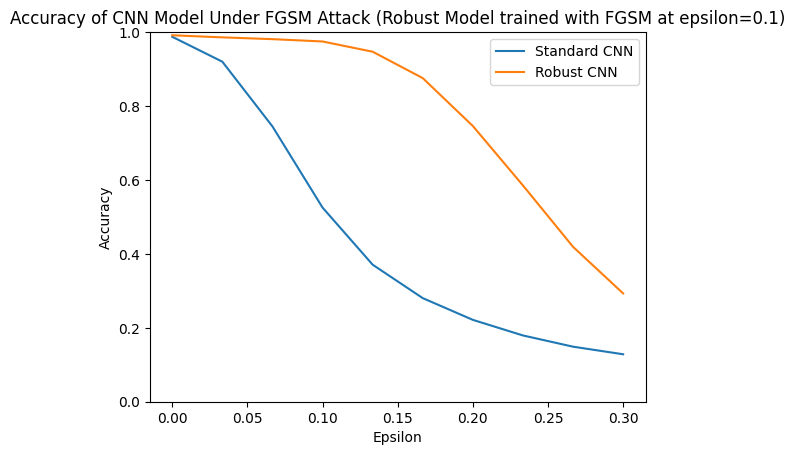

In [61]:
#plot the accuracy as a function of epsilon
plt.plot(np.linspace(0, 0.3, 10), cnn_accs_for_epsilons, label="Standard CNN")
plt.plot(np.linspace(0, 0.3, 10), robust_cnn_accs_for_epsilons, label="Robust CNN")

plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.ylim([0, 1])
plt.title("Accuracy of CNN Model Under FGSM Attack (Robust Model trained with FGSM at epsilon=0.1)")
plt.legend()
plt.show()

##### This validates that adversarial training works for making our models more robust to adversarial input. It is interesting to note that the adversrial training is effect for making the model robust to takes of not only epsilon of 0.1, but also other epsilon values. This is a good sign that the model is learning to be robust to adversarial input. But, we don't know if the model is robust to all possible adversarial input. Let's try an example of adversarial input from a different method.

In [62]:
def pgd_linf(model, X, y, loss_fn, epsilon=0.1, alpha=0.01, num_iter=20, randomize=False):
    print("calling PGD with epsilon={}, alpha={}, num_iter={}, randomize={}".format(epsilon, alpha, num_iter, randomize))
    """ Construct FGSM adversarial examples on the examples X"""
    if randomize:
        delta = torch.rand_like(X, requires_grad=True)
        delta.data = delta.data * 2 * epsilon - epsilon
    else:
        delta = torch.zeros_like(X, requires_grad=True)
        
    for t in range(num_iter):
        loss = loss_fn(model(X + delta), y)
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

In [68]:
robust_cnn_accs_for_epsilons_pgd = evaluate_model_accuracy_for_epsilons(robust_model_cnn, test_loader, robust_model_cnn_loss_fn, pgd_linf, np.linspace(0, 0.3, 10), alpha=0.01, num_iter=40)

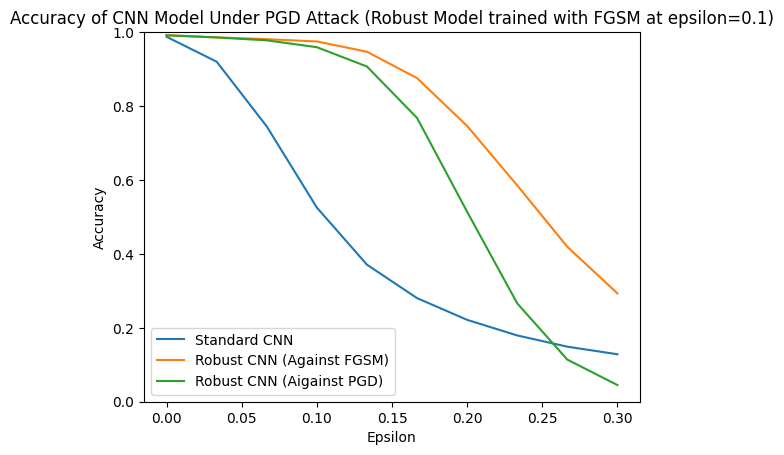

In [72]:
#plot the accuracy as a function of epsilon
plt.plot(np.linspace(0, 0.3, 10), cnn_accs_for_epsilons, label="Standard CNN")
plt.plot(np.linspace(0, 0.3, 10), robust_cnn_accs_for_epsilons, label="Robust CNN (Against FGSM)")
plt.plot(np.linspace(0, 0.3, 10), robust_cnn_accs_for_epsilons_pgd, label="Robust CNN (Aigainst PGD)")

plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.ylim([0, 1])
plt.title("Accuracy of CNN Model Under PGD Attack (Robust Model trained with FGSM at epsilon=0.1)")
plt.legend()
plt.show()

In [73]:
#now let's try and train a robust model using PGD
robust_model_cnn_pgd = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
                          nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                          Flatten(),
                          nn.Linear(7*7*64, 100), nn.ReLU(),
                          nn.Linear(100, 10)).to(device)

robust_model_cnn_pgd_optimizer = optim.SGD(robust_model_cnn_pgd.parameters(), lr=1e-1)
robust_model_cnn_pgd_loss_fn = nn.CrossEntropyLoss()

In [74]:
#train the model using PGD
results_pgd = train_robust_model(robust_model_cnn_pgd, train_loader, test_loader, robust_model_cnn_pgd_loss_fn, robust_model_cnn_pgd_optimizer, 10, pgd_linf, 0.1, alpha=0.01, num_iter=40)

Train Loss	Test Loss	Adv Loss	Train Accuracy	Test Accuracy	Adv Accuracy
1.609360	0.147737	0.376730	0.398267	0.958700	0.880300
0.259957	0.063165	0.184950	0.914900	0.981100	0.936500
0.157008	0.045443	0.134498	0.948333	0.986200	0.954700
0.118230	0.035403	0.108017	0.960567	0.988900	0.965000
0.094433	0.032232	0.099606	0.968567	0.988900	0.967900
0.079613	0.031200	0.093990	0.973583	0.990100	0.969300
0.069338	0.028627	0.093589	0.976583	0.990400	0.968700
0.059779	0.027691	0.085559	0.979567	0.990300	0.971700
0.052846	0.024953	0.081582	0.981800	0.991400	0.974300
0.045991	0.023266	0.078164	0.984517	0.992200	0.975800
